# 16S Analysis Decontamination Pipeline

## Version and History

This pipeline was created by Rose Kantor and adapted for use by Hannah Greenwald. This is the second pipeline file in the series used to process amplicon sequencing data.

Anyone seeking to use this code will need to change the directories and place files in the proper directory with the data.

# Load libraries and data

In [ ]:
#uncomment to install packages

# BiocManager::install("decontam")
# BiocManager::install("DESeq2")

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2) ; packageVersion("dada2")
library(decontam) ; packageVersion("decontam")
library(ggplot2); packageVersion("ggplot2")
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(Biostrings); packageVersion("Biostrings")
library(tidyr)
library(dplyr)
library(scales)
library(repr)
library(reshape2)
library(genefilter)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.38.0’

Loading required package: Rcpp



[1] ‘1.16.0’

[1] ‘1.14.0’

[1] ‘3.3.5’

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7



[1] ‘2.5.7’

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: ‘IRanges’


The following object is masked from ‘package:phyloseq’:

    distance


Loading required package: GenomicRanges

Loading required p

[1] ‘1.34.0’

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit




[1] ‘2.62.0’


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘

In [2]:
ps_raw <- readRDS("./phyloseq_object.rds")
ps_raw

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2591 taxa and 109 samples ]
sample_data() Sample Data:       [ 109 samples by 118 sample variables ]
tax_table()   Taxonomy Table:    [ 2591 taxa by 6 taxonomic ranks ]

In [5]:
#make "combined" column in tax table
ranks <- c("Phylum", "Family", "Genus")
combined_labels <- apply(tax_table(ps_raw)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
tax_table(ps_raw) <- cbind(tax_table(ps_raw), combined=combined_labels)


In [7]:
#remove samples with too few reads
min_reads <- 1000 #change from 7500 to 1000 to preserve an additional negative control
ps <- prune_samples(sample_sums(ps_raw)>=min_reads, ps_raw) #remove failed samples
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2591 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 118 sample variables ]
tax_table()   Taxonomy Table:    [ 2591 taxa by 7 taxonomic ranks ]

In [8]:
sample_data(ps)$qubit_clean <- sample_data(ps)$qubit_ngul
sample_data(ps)$qubit_clean[sample_data(ps)$qubit_clean == "toolow"] <- 0.001
sample_data(ps)$qubit_clean <- as.numeric(sample_data(ps)$qubit_clean)

# Number of reads per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



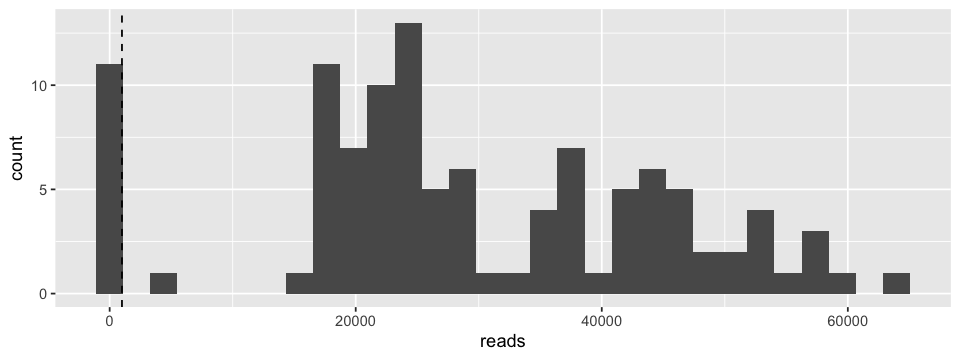

In [9]:
read_counts <- as.data.frame(rowSums(otu_table(ps_raw)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()+
    geom_vline(xintercept=min_reads, linetype='dashed')

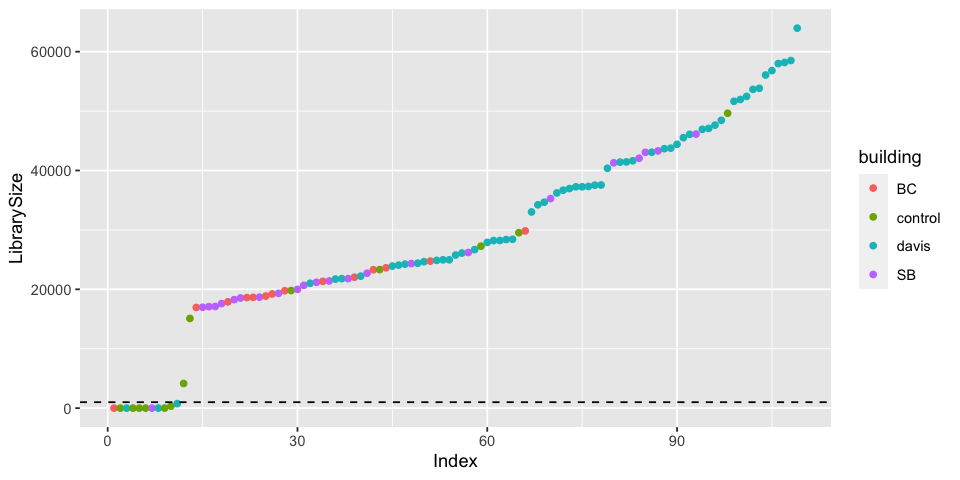

In [10]:
df <- as.data.frame(sample_data(ps_raw)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_raw)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=building))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')


# Number of ASVs per sample, including controls

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


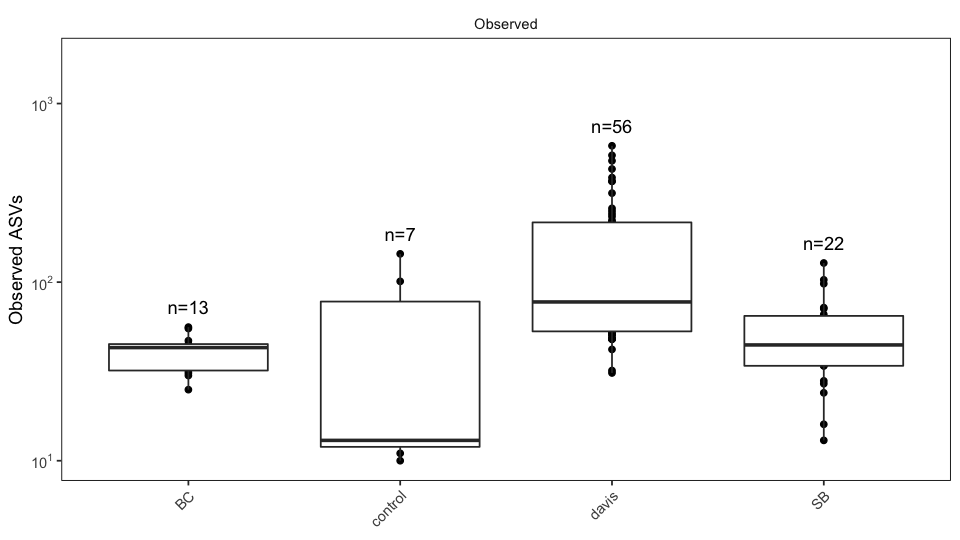

In [12]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 8, repr.plot.height = 4.5)
plot_richness(ps, x="building", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)

#controls include both positive and negative controls

# Examine successful positive controls

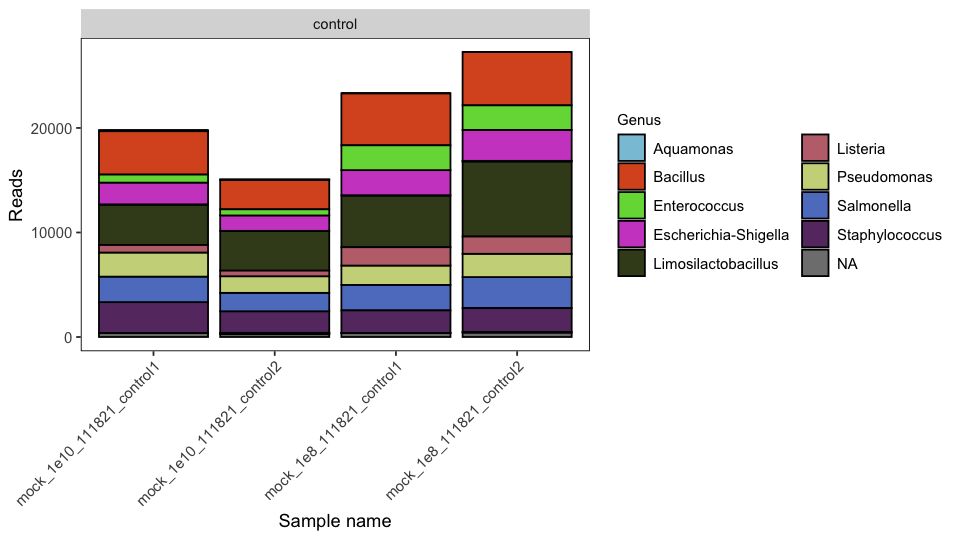

In [13]:
ps_mock <- subset_samples(ps, subset = tap_code %in% c("mock"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 10, TRUE) #keep only seqs that had reads in mock(s)

options(repr.plot.width = 8, repr.plot.height = 4.5)

plot_bar(ps_mock, x="Sample", fill="Genus") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~building, scale="free_x", space="free_x")+
ylab("Reads") + #used to say Percent relative abundance
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))
                       
#looks like aquamonas is a small contaminant 

**positive extraction controls with 10^10, 10^8, and 10^6 (failed) cells input, respectively.**

In [14]:
#make table of mock sequences
ps_mock <- subset_samples(ps, subset = tap_code %in% c("mock"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)
mock_tax <- as.data.frame(tax_table(ps_mock))
mock_otu <- as.data.frame(otu_table(ps_mock))
mock_otu <- t(mock_otu)
mock_tab <- merge(mock_otu, mock_tax, by=0)
row.names(mock_tab) <- mock_tab$Row.names
mock_tab <- subset(mock_tab, select = -c(Row.names))
# mock_tab <- mock_tab[order(-mock_tab$SD039), ] # sort in descending order
# head(mock_tab)
mock_seqs <- row.names(mock_tab)
#mock_seqs <- as.data.frame(refseq(ps_mock))
#merge(mock_tab, mock_seqs, by.x="Row.names", by.y=names)

In [15]:
# load reference sequences for mock controls and compare:
mock.ref <- getSequences("~/Documents/Documents/Berkeley_Research/Stagnation/16S_analysis_2022/ZymoBIOMICS.STD.refseq.v2/ssrRNAs/")
#created this single fasta file by downloading zipped folder of refs from Zymo and using command line: cat *.fasta > mock_seqcombined.fasta
#not working, maybe I need a different way to construct the fasta

# identify matches to references, anything else is contamination
match.ref <- sapply(mock_seqs, function(x) any(grepl(x, mock.ref)))
match.ref <- as.data.frame(match.ref)

In [16]:
mock_tab <- merge(mock_tab, match.ref, by=0)
row.names(mock_tab) <- mock_tab$Row.names
mock_tab <- subset(mock_tab, select = -c(Row.names))
mock_tab <- mock_tab[order(-match.ref), ] # sort in descending order

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


In [1]:
mock_tab

ERROR: Error in eval(expr, envir, enclos): object 'mock_tab' not found


**All genera that should be in the Zymo mock are there.** There are 8 sequences detected that are not in the reference sequences of the mock community, each found in mostly just one sample indicating it's a contaminant and not a mutation in the actual stock. 

In [18]:
# collect all mock taxa to remove them later
mock_taxa <- row.names(mock_tab[1:10,])
mock_taxa_contaminant <- row.names(mock_tab[11:18,])

In [19]:
# filter mock taxa out of the mock samples so that we can study them with the negative controls
ps_mock <- subset_samples(ps, subset = (tap_code %in% c("mock")))
ps_mock_cont <- prune_taxa(mock_taxa_contaminant, ps_mock) #only leave contaminants in mock

ps_full_mock <- ps #preserve a ps that still has mocks with full community
ps <- subset_samples(ps, subset = !(tap_code %in% c("mock"))) #take out mocks
ps <- merge_phyloseq(ps, ps_mock_cont) #add back in mocks but only with contaminants (to use as neg controls)


# Negative controls and overlaps with samples

In [20]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))


## Collect sets of taxa, identify taxa found in both blanks and samples for further investigation

In [21]:
ps_samp <- subset_samples(ps, subset = !(building %in% c("control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = tap_code %in% c("bottle", "bag", "control_bottle", "pcrneg", "filterblank", "tripblank", "mock"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_samp_blank <- merge_phyloseq(ps_blank, ps_samp)
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2584 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 2584 taxa by 7 taxonomic ranks ]

In [22]:
blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

In [23]:
length(samp_only_taxa)

[1] 2327

## Plot intersecting taxa (found in blanks and samples)

In [24]:
#for plotting, get intersecting taxa, include mocks
ps_intersecting <- prune_taxa(intersecting_taxa, ps)
ps_intersecting

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 116 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 116 taxa by 7 taxonomic ranks ]

In [25]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))
#
ps_intersecting_perc <- prune_taxa(intersecting_taxa, ps_perc)
ps_intersecting_perc <- filter_taxa(ps_intersecting_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_intersecting_perc_filt5 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(1, 5)), TRUE)
ps_intersecting_perc_filt2 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(1, 2)), TRUE)
                                    #is this intersecting taxa where at least 2 samples have to have at least 5% reads?
                                    #maybe change to 1 sample 

In [26]:
ps_intersecting_perc_filt2
ps_intersecting_perc_filt5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 22 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 13 taxa by 7 taxonomic ranks ]

**Upon visual inspection, Major contaminants are Bejerinckiaceae, Comamonadaceae, Vibrionaceae, Pseudoalteromonadaceae**

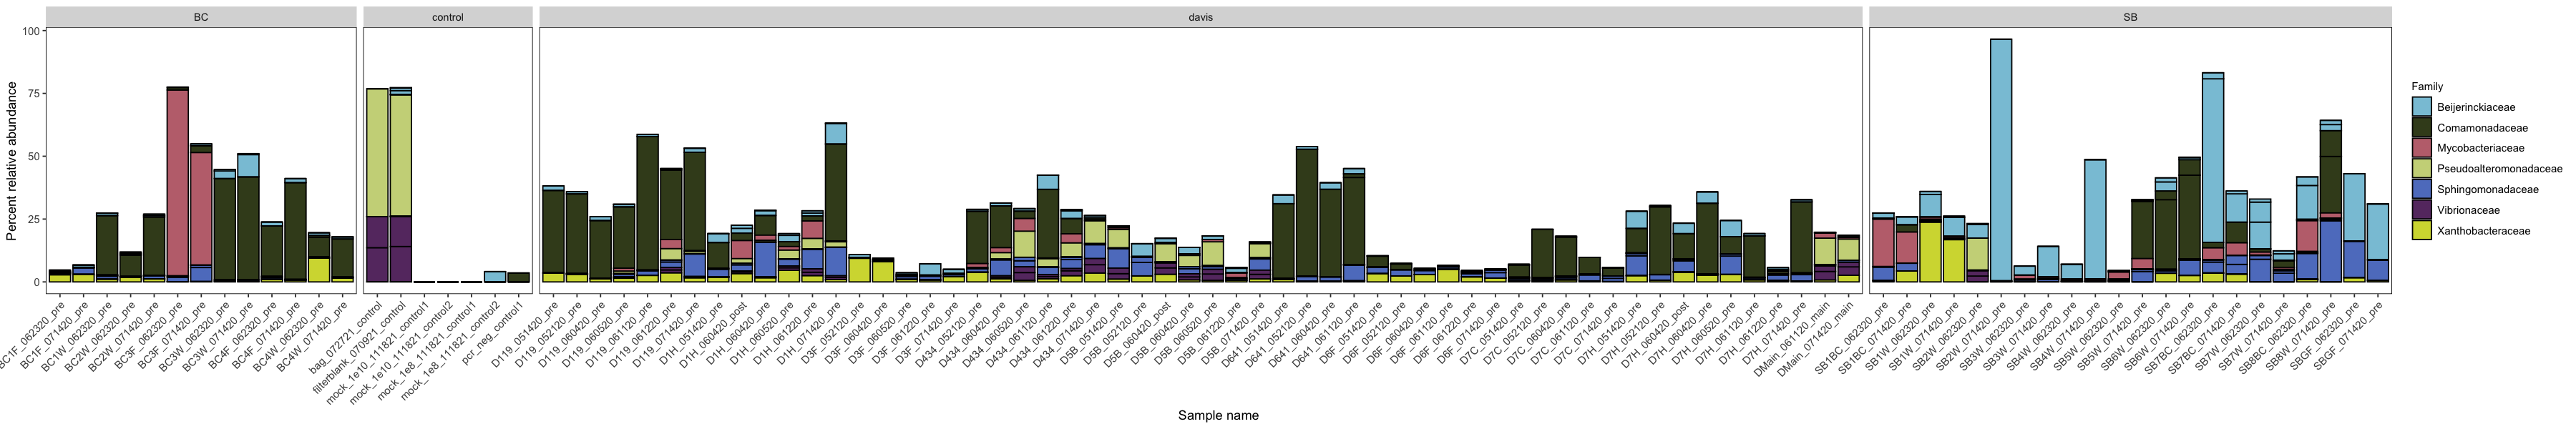

In [27]:
options(repr.plot.width = 30, repr.plot.height = 5)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_intersecting_perc_filt5, x="Sample", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    #facet_wrap(~location_code, nrow=4, scale="free_x")
    facet_grid(.~building, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))
# ggsave('~/data/awtp2_16S/barplot_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=5)

Warning message:
“Transformation introduced infinite values in discrete y-axis”


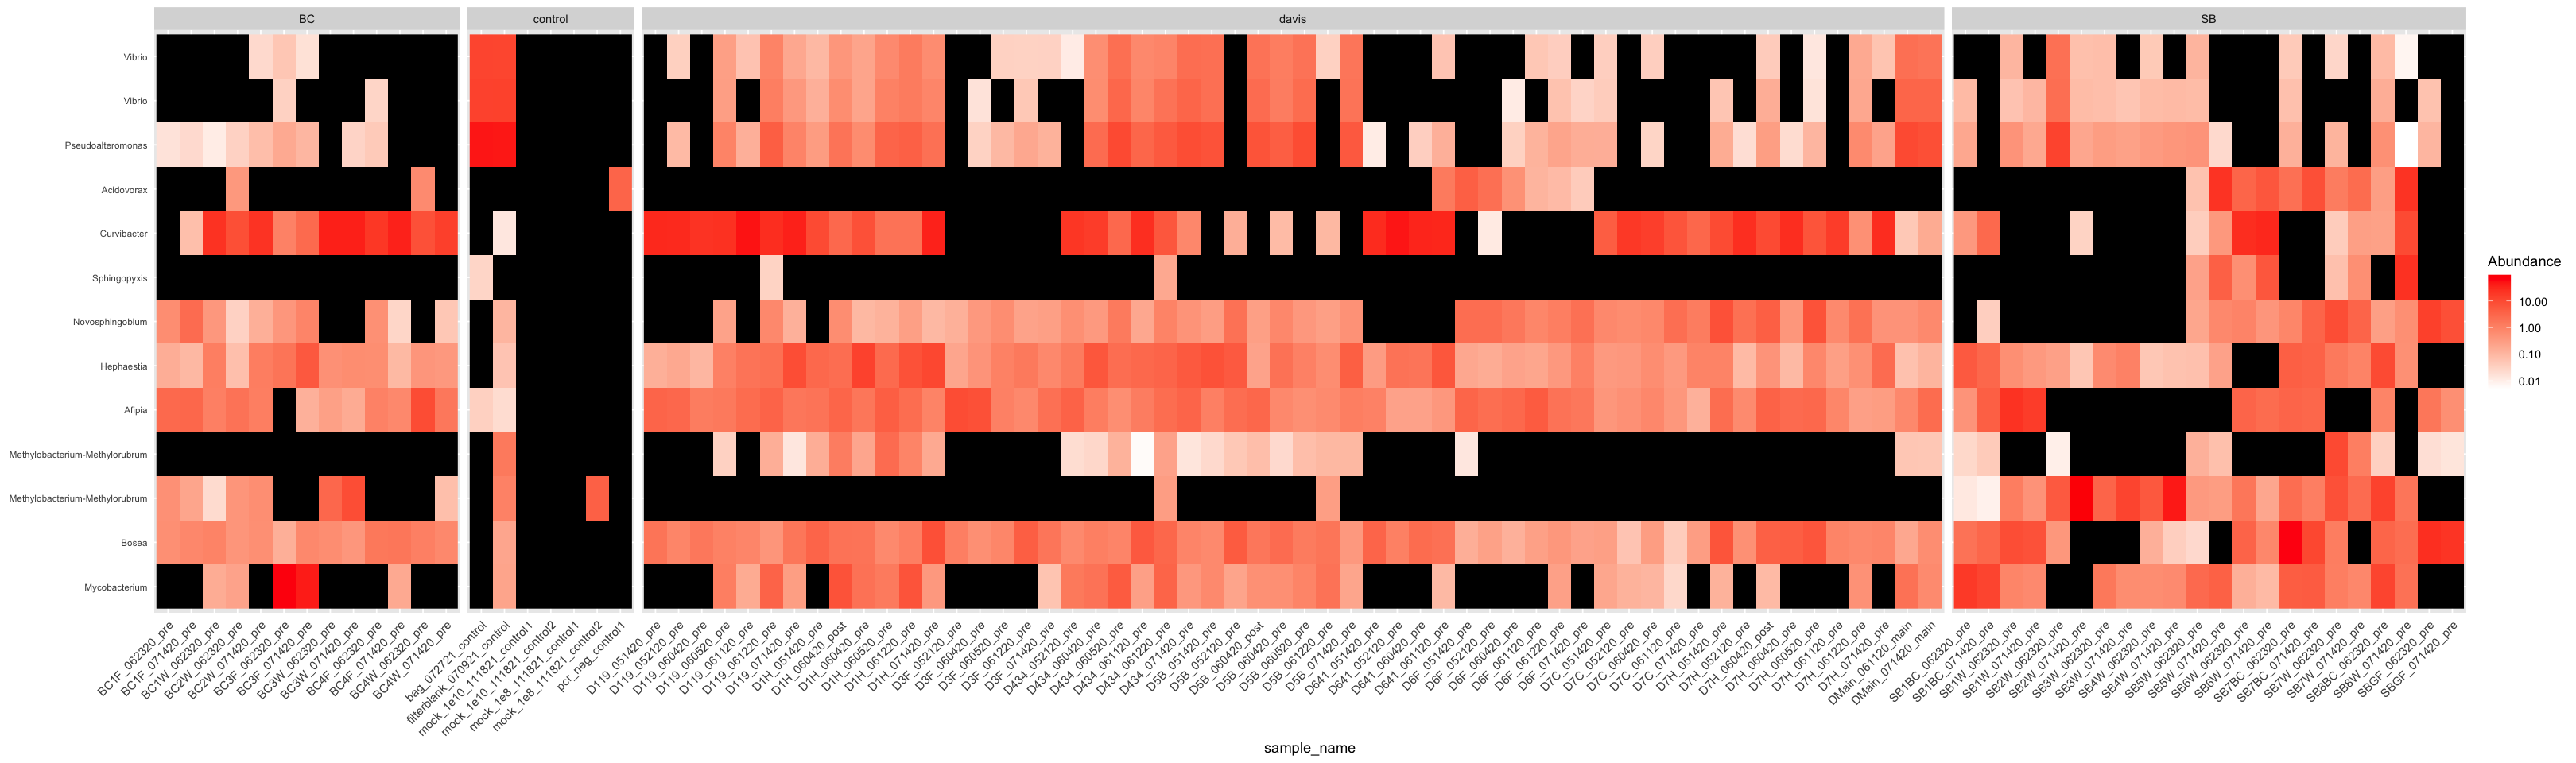

In [28]:
#plot heatmap
options(repr.plot.width = 27, repr.plot.height = 8)
plot_heatmap(ps_intersecting_perc_filt5, taxa.label = "Genus", sample.label = "sample_name", sample.order = "sample_name", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
# ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=9)


these help us try to figure out contaminants by eye and then use deseq 
pseudoalteromonas likely contaminant (high in neg control, low in samples, consistent )

## Cross-contamination coming from positive control into samples/blanks

Warning message:
“Transformation introduced infinite values in discrete y-axis”


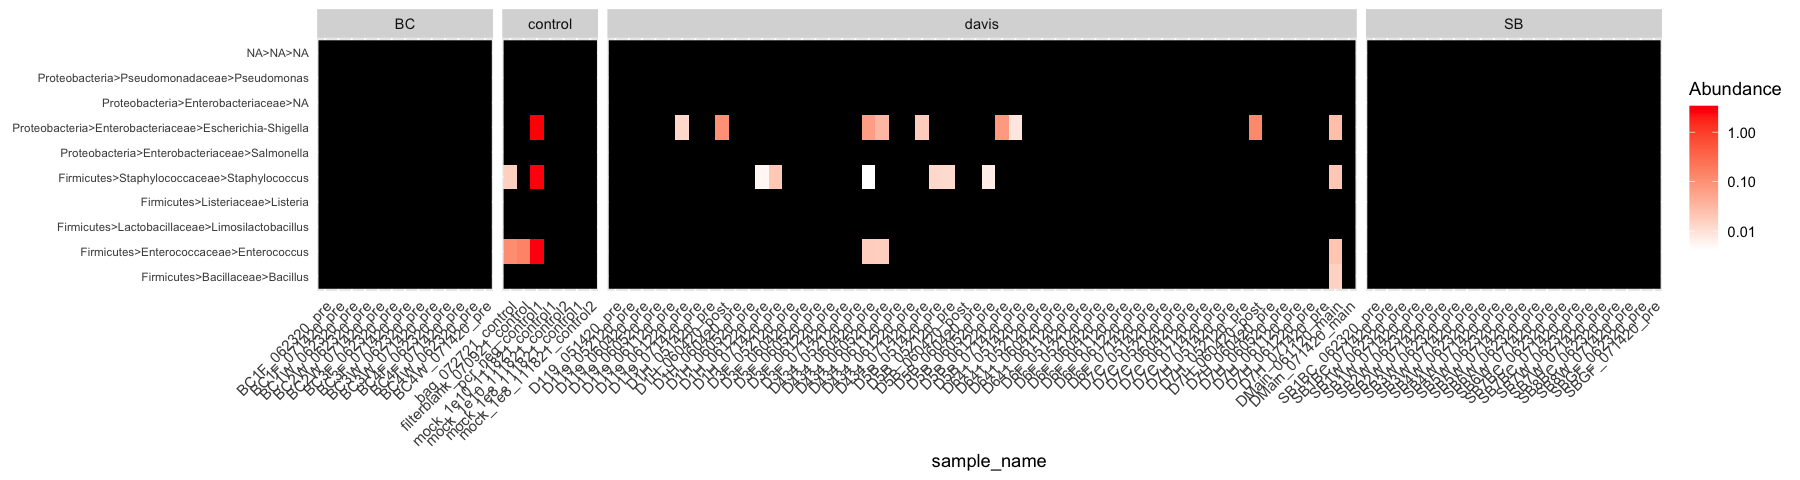

In [29]:
ps_mock_in_all_perc <- prune_taxa(mock_taxa, ps_perc)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 4)
plot_heatmap(ps_mock_in_all_perc, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_mock_in_all.png', device='png', width=20, height=4)

# Decontamination

In [30]:
length(blank_taxa)
length(samp_taxa)
length(intersecting_taxa)

[1] 257

[1] 2443

[1] 116

In [31]:
#for decontamination: Get all taxa found in samples, include blanks in ps object.
#ps_samp_blank_for_decontam <- prune_taxa(samp_taxa, ps_samp_blank)
ps_samp_blank_for_decontam <- ps_samp_blank
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2584 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 2584 taxa by 7 taxonomic ranks ]

## Remove mock taxa from dataset (including the taxa that are present in some samples)

In [32]:
allTaxa = taxa_names(ps_samp_blank_for_decontam)
allTaxa_minus_mock <- allTaxa[!(allTaxa %in% mock_taxa)]
ps_samp_blank_for_decontam <- prune_taxa(allTaxa_minus_mock, ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2580 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 119 sample variables ]
tax_table()   Taxonomy Table:    [ 2580 taxa by 7 taxonomic ranks ]

## Redefine intersecting taxa (found in blanks and samples) now that samples have been curated

In [33]:
ps_samp <- subset_samples(ps, subset = !(building %in% c("control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = tap_code %in% c("bottle", "bag", "control_bottle", "pcrneg", "filterblank", "tripblank", "mock"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
length(intersecting_taxa)

[1] 116

In [34]:
length(samp_only_taxa)

[1] 2327

## DESeq2-guided subtractive decontamination method

Note: the result is the same if ALL taxa from blanks are included and if only taxa in both blanks and samples are included

In [35]:
#set factor levels so "control" comes first
sample_data(ps_samp_blank_for_decontam)$ctrl_samp <- sample_data(ps_samp_blank_for_decontam)$building
sample_data(ps_samp_blank_for_decontam)$ctrl_samp[sample_data(ps_samp_blank_for_decontam)$ctrl_samp == "davis"] <- "sample"
sample_data(ps_samp_blank_for_decontam)$ctrl_samp[sample_data(ps_samp_blank_for_decontam)$ctrl_samp == "SB"] <- "sample"
sample_data(ps_samp_blank_for_decontam)$ctrl_samp[sample_data(ps_samp_blank_for_decontam)$ctrl_samp == "BC"] <- "sample"
sample_data(ps_samp_blank_for_decontam)$ctrl_samp <- factor(sample_data(ps_samp_blank_for_decontam)$ctrl_samp, levels=c("control", "sample"))

In [36]:
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2580 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 2580 taxa by 7 taxonomic ranks ]

In [37]:
#run DESeq on all samples vs blanks
# following: https://bioconductor.org/packages/devel/bioc/vignettes/phyloseq/inst/doc/phyloseq-mixture-models.html

diagdds_full = phyloseq_to_deseq2(ps_samp_blank_for_decontam, ~ ctrl_samp)

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds_full), 1, gm_mean)
diagdds_full = estimateSizeFactors(diagdds_full, geoMeans = geoMeans)
diagdds_full = DESeq(diagdds_full, test="Wald", fitType="local")

res_full = results(diagdds_full, cooksCutoff = FALSE)
res_full = res_full[order(res_full$padj, na.last=NA), ]

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 673 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [38]:
alpha = 0.01
sigtab_full = res_full[(res_full$padj < alpha), ]
sigtab_full = cbind(as(sigtab_full, "data.frame"), as(tax_table(ps_samp_blank_for_decontam)[rownames(sigtab_full), ], "matrix"))

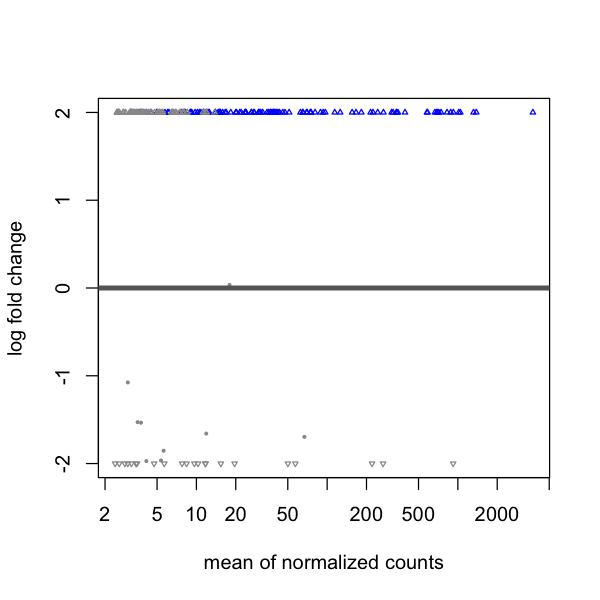

In [39]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res_full, ylim=c(-2,2))

In [40]:
significant_taxa <- row.names(sigtab_full[sigtab_full$log2FoldChange > 0,]) #what is significantly enriched in samples over blanks?
# head(significant_taxa)
posigtab = sigtab_full[sigtab_full[, "log2FoldChange"] > 0, ]
posigtab = posigtab[, c("baseMean", "log2FoldChange", "lfcSE", "padj", "Phylum", "Class", "Family", "Genus")]
posigtab

,baseMean,log2FoldChange,lfcSE,padj,Phylum,Class,Family,Genus
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,1383.85517,28.84919,1.564764,1.458669e-73,Proteobacteria,Alphaproteobacteria,Beijerinckiaceae,Microvirga
AGGTGGCAAGCGTTGTTCGGATTCACTGGGCGTACAGGGAGCGTAGGCGGTTGGGTAAGCCCTCCGTGAAATCTCCGGGCCTAACCCGGAAAGTGCAGAGGGGACTGCTCAGCTAGAGGATGGGAGAGGAGCGCGGAATTCCCGGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAAGGCCGGTGGCGAAGGCGGCGCTCTGGAACATTTCTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,688.56221,27.94228,1.661237,1.267982e-61,Nitrospirota,Nitrospiria,Nitrospiraceae,Nitrospira
AGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGACAGTTTAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTGGCTGTCTTGAGTACGGGAGAGGTGAGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTCACTGGCCCGTTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,826.70559,28.19645,1.674866,1.267982e-61,Proteobacteria,Alphaproteobacteria,Caulobacteraceae,Phenylobacterium
AGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCCTTGAAACTGGGAAGCTAGAATCTTGGAGAGGCGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTCGCTGGACAAGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,338.59170,26.92514,1.694120,3.861355e-55,Proteobacteria,Alphaproteobacteria,Sphingomonadaceae,Porphyrobacter
AGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCCATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATGGCTTGAATCTTGGAGAGGCGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTCGCTGGACAAGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,1017.25784,27.11353,1.787754,2.591025e-50,Proteobacteria,Alphaproteobacteria,Sphingomonadaceae,Blastomonas
AGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGACATTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTGGATGTCTTGAGTTCGGGAGAGGTGAGTGGAATGCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGCGGAACACCAGTGGCGAAGGCGACTCACTGGCCCGATACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,586.59640,26.63364,1.774804,2.428833e-49,Proteobacteria,Alphaproteobacteria,Caulobacteraceae,Phenylobacterium
AGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACGAGAAAGTCAGAGGTGAAATCCCAGGGCTCAACCTTGGAACTGCCTTTGAAACTTCTTGTCTTGAGGTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,579.87974,24.86520,1.702550,8.203979e-47,Proteobacteria,Alphaproteobacteria,Rhodobacteraceae,Rhodobacter
AGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGTGGGCAAGTAAGTCAGTGGTGAAATCTCTGGGCTTAACCCGGAAACTGCCATTGATACTATTTGTCTTGAATTCTCTGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCTTAGATATGACATAGAACACCCATTGCGAAGGCAGCTTACTACGGAGACATTGACACTGAGGCACGAAAGCGTGGGGATCAAACA,667.47730,27.89224,1.955070,9.671199e-45,Bacteroidota,Bacteroidia,Chitinophagaceae,Lacibacter
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTATAGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,155.31501,25.78454,1.903465,2.032968e-40,Proteobacteria,Gammaproteobacteria,Comamonadaceae,Acidovorax


### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [41]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples <- setdiff(intersecting_taxa, significant_taxa)
length(samples_over_blanks)
length(blanks_over_samples) #108 but not significantly enriched 

[1] 8

[1] 108

### Heatmaps of taxa to remove and taxa to keep

Warning message:
“Transformation introduced infinite values in discrete y-axis”


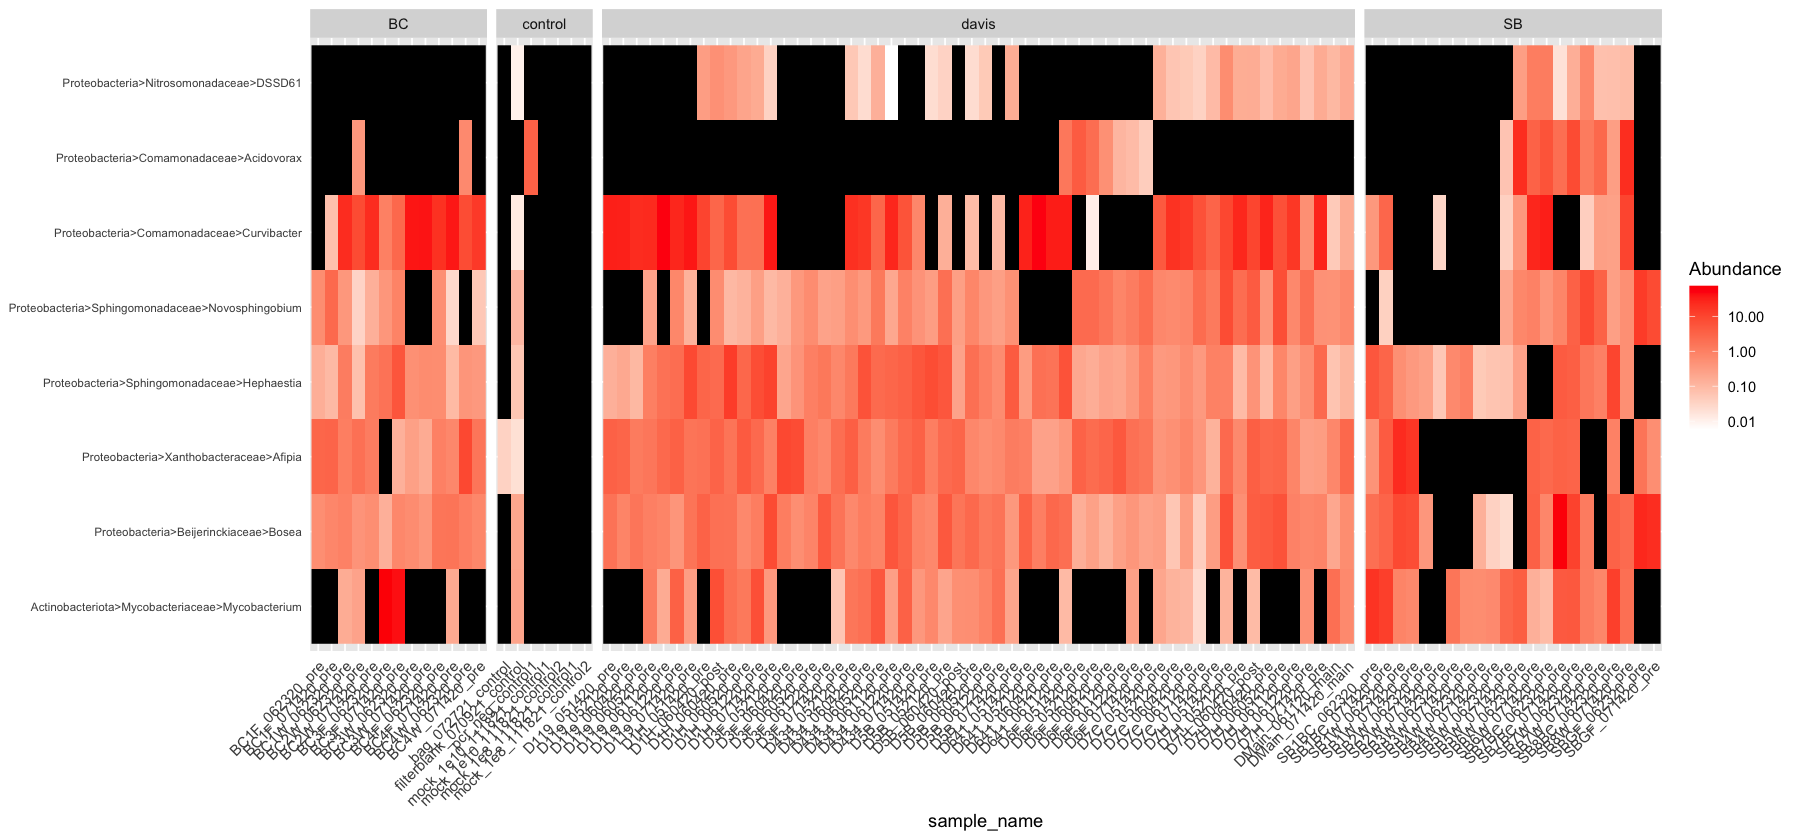

In [42]:
ps_perc_samples_over_blanks <- prune_taxa(samples_over_blanks, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_samples_over_blanks, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=4)

Warning message:
“Transformation introduced infinite values in discrete y-axis”


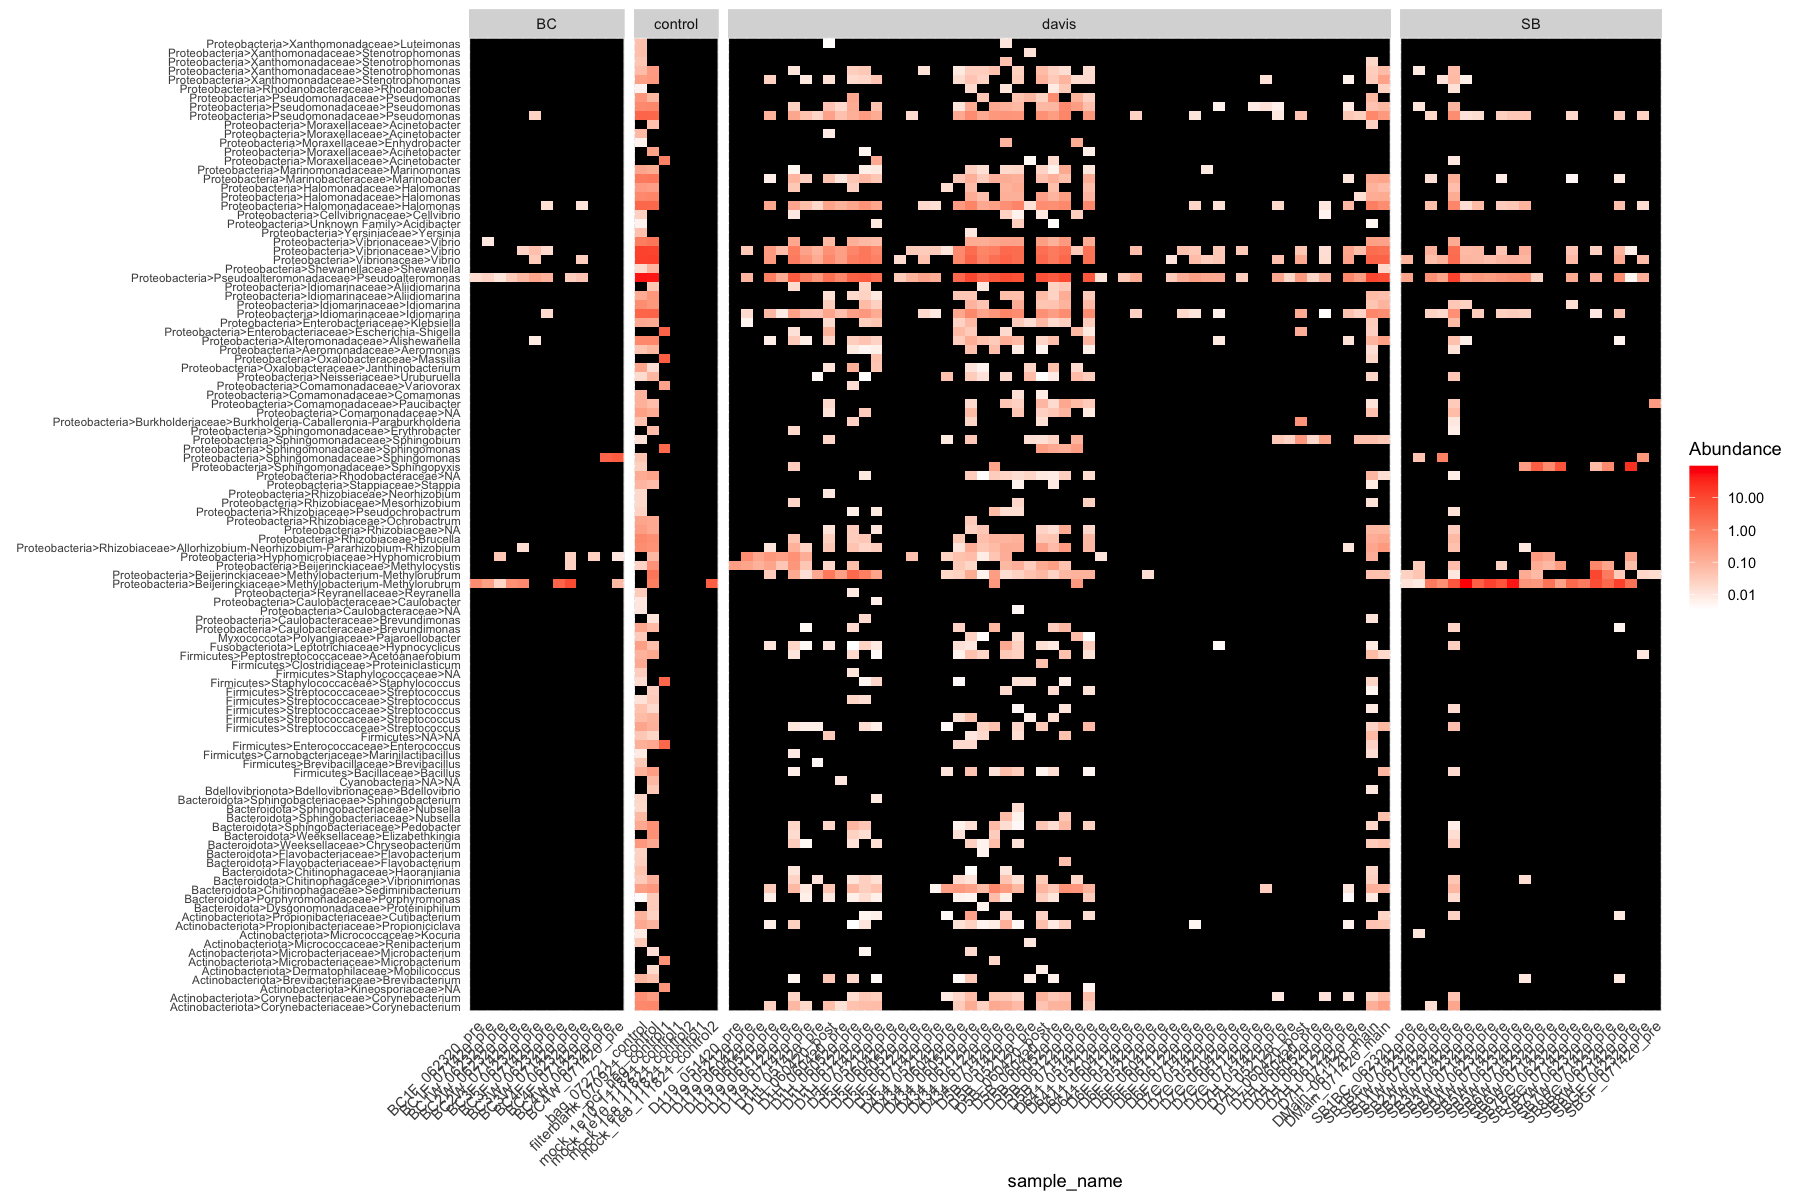

In [43]:
ps_perc_blanks_over_samples <- prune_taxa(blanks_over_samples, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 10)
plot_heatmap(ps_perc_blanks_over_samples, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_blanks_over_samples', device='png', width=25, height=15)

### Combine to get taxa from sample-only and taxa significant by DESeq, convert to relative abundance of remaining reads

In [44]:
ps_clean <- prune_taxa(taxa=union(significant_taxa, samp_only_taxa), ps)
sample_data(ps_clean)$filtered_readcounts <- sample_sums(ps_clean)
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2335 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 2335 taxa by 7 taxonomic ranks ]

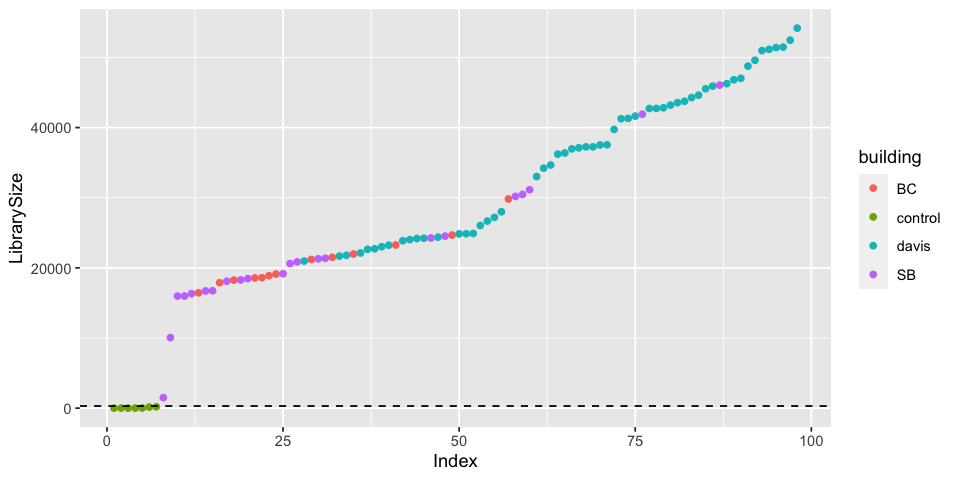

In [45]:
min_reads <- 300
df <- as.data.frame(sample_data(ps_clean)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_clean)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=building))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')

*this pipeline removes all controls and keeps all samples*

## Save the RDS to move forward with

In [46]:
ps_clean_filt <- prune_samples(sample_sums(ps_clean)>=300, ps_clean) #remove samples now with too few reads
ps_clean_filt <- filter_taxa(ps_clean_filt, filterfun(kOverA(1, 0)), TRUE)
ps_clean_perc <- transform_sample_counts(ps_clean_filt, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_clean
ps_clean_filt

saveRDS(ps_clean_filt, "~/Documents/Documents/Berkeley_Research/Stagnation/16S_analysis_2022/ps_clean_filt.rds")
saveRDS(ps_clean_perc, "~/Documents/Documents/Berkeley_Research/Stagnation/16S_analysis_2022/ps_clean_perc.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2335 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 2335 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2335 taxa and 91 samples ]
sample_data() Sample Data:       [ 91 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 2335 taxa by 7 taxonomic ranks ]

### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [47]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples <- setdiff(intersecting_taxa, significant_taxa)
length(samples_over_blanks)
length(blanks_over_samples)

[1] 8

[1] 108

## Decontam frequency method

In [49]:
contamdf.freq <- isContaminant(ps_samp, method="frequency", conc="qubit_clean", threshold = .1) 
#default is 0.1 but some suggest 0.5


In [50]:
table(contamdf.freq$contaminant)
head(which(contamdf.freq$contaminant))


FALSE  TRUE 
 2438     5 

[1]    6  533  542  628 1288

In [51]:
decontam_freq_contams <- row.names(contamdf.freq[contamdf.freq$contaminant==TRUE,])

In [52]:
decontam_freq_intersect <- intersect(decontam_freq_contams, intersecting_taxa)

**The decontam frequency method identified 5 ASVs that were part of the intersection of negative controls and samples.**

Warning message:
“Transformation introduced infinite values in discrete y-axis”


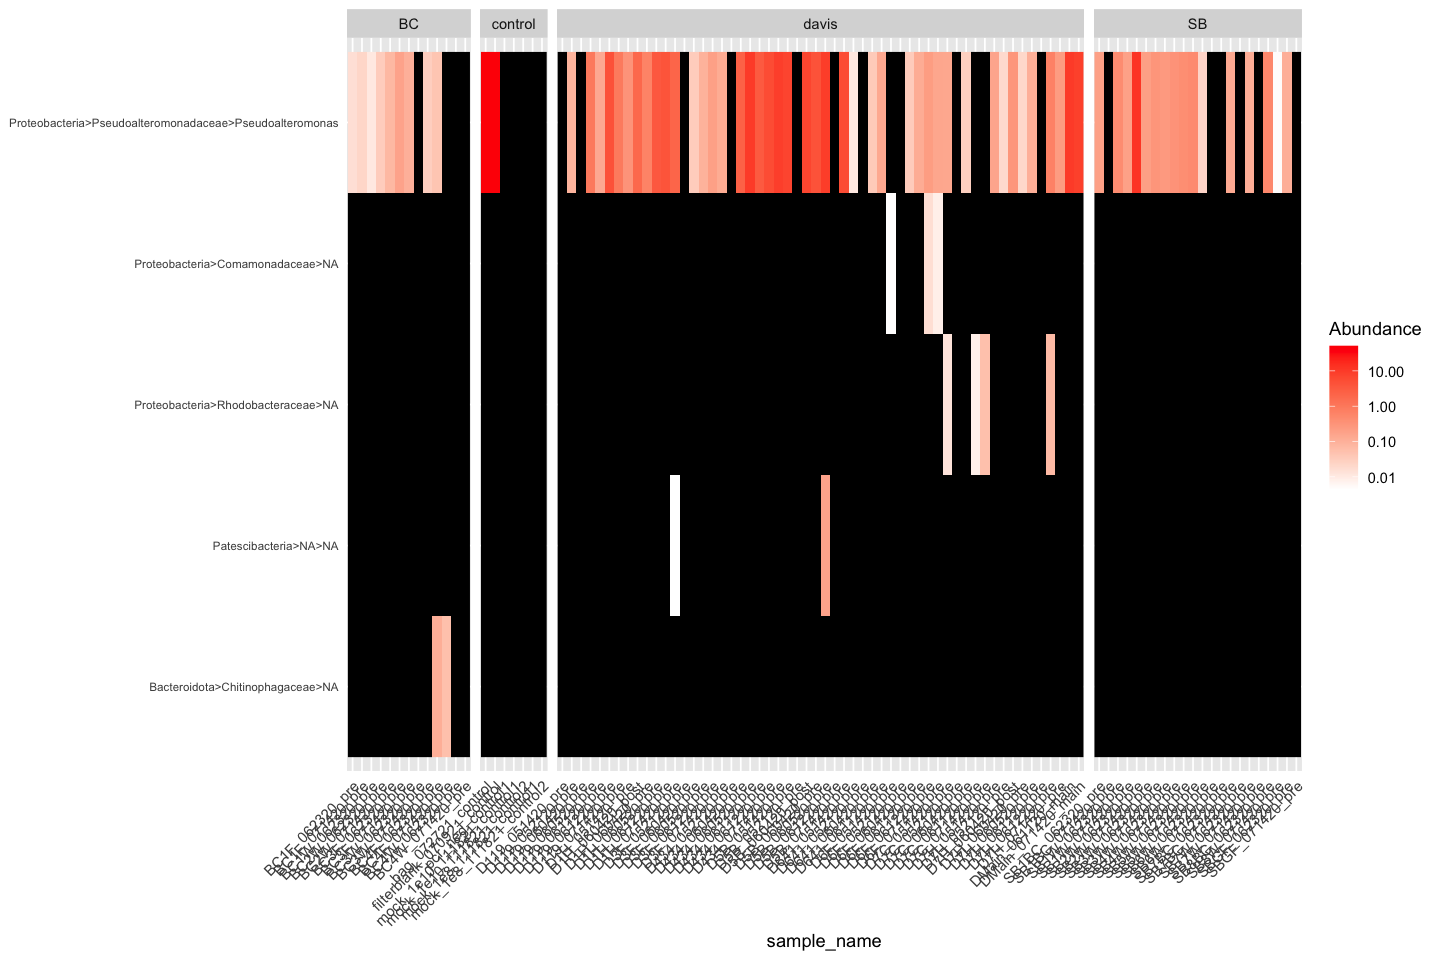

In [53]:
ps_decontam_freq_contams <- prune_taxa(decontam_freq_contams, ps_perc)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_freq_contams, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_contams.png', device='png', width=20, height=9)

## Decontam prevalence method

In [54]:
ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = building %in% c("control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 254 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 254 taxa by 7 taxonomic ranks ]

In [56]:
samp_names <- sample_names(ps_samp)
blanks <- sample_names(subset_samples(ps_samp_blank_for_decontam, subset = (building %in% c("control"))))

ps_samp_blank_for_decontam <- prune_samples(c(samp_names, blanks), ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam <- filter_taxa(ps_samp_blank_for_decontam, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2580 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 120 sample variables ]
tax_table()   Taxonomy Table:    [ 2580 taxa by 7 taxonomic ranks ]

In [57]:
sample_data(ps_samp_blank_for_decontam)$is.neg <- sample_data(ps_samp_blank_for_decontam)$building == "control"
contamdf.prev <- isContaminant(ps_samp_blank_for_decontam, method="prevalence", neg="is.neg", threshold = .1)
table(contamdf.prev$contaminant)


FALSE  TRUE 
 2546    34 

In [58]:
decontam_prev_contams <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])

Warning message:
“Transformation introduced infinite values in discrete y-axis”


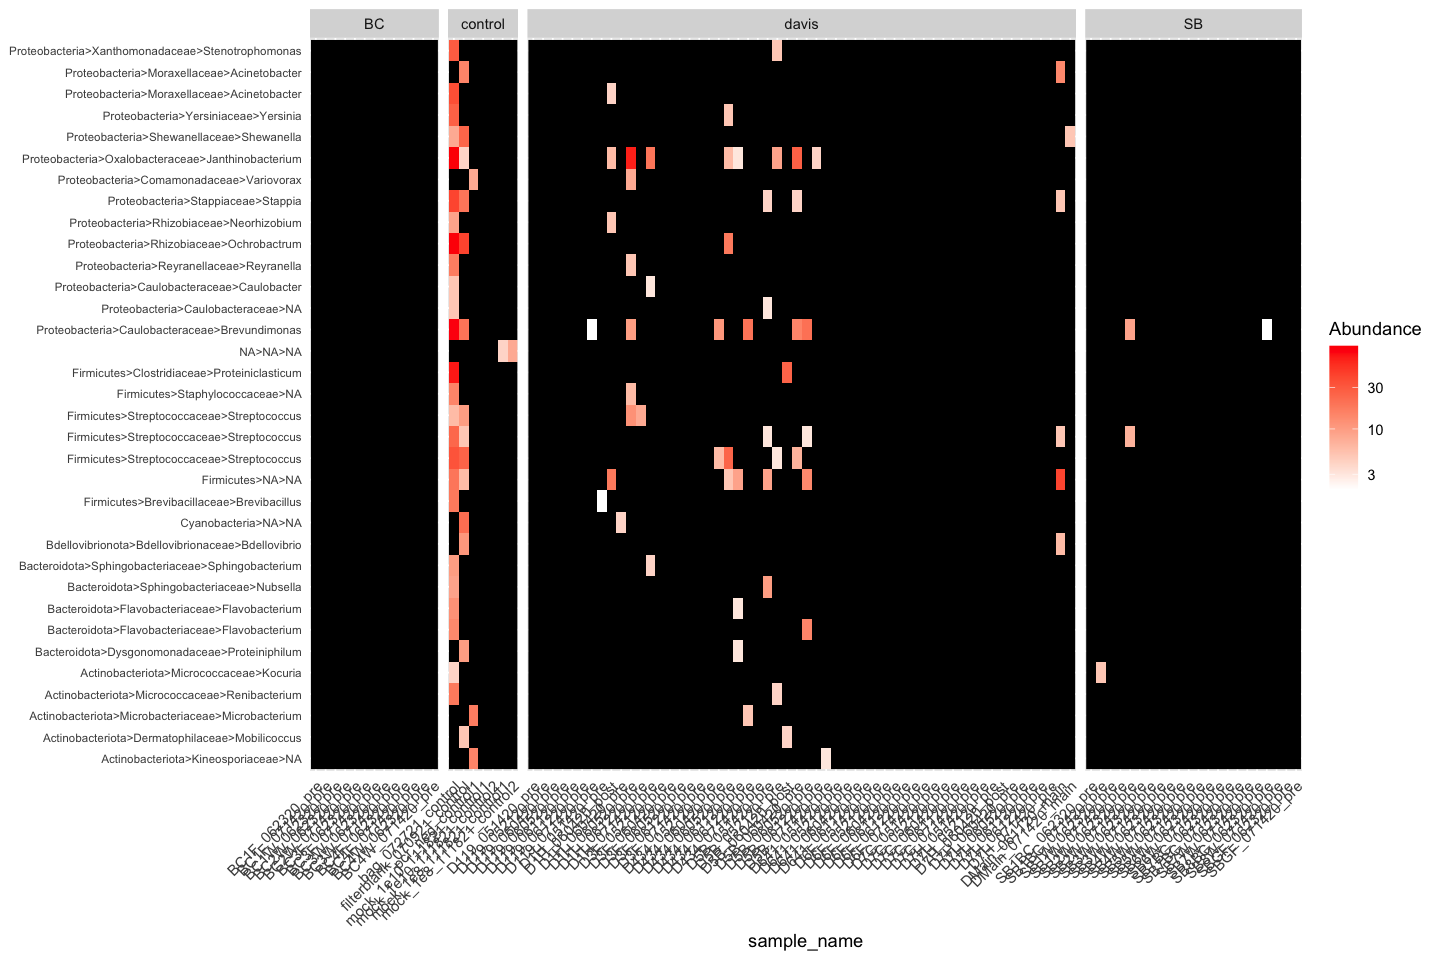

In [59]:
ps_decontam_prev_contams <- prune_taxa(decontam_prev_contams, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_prev_contams.png', device='png', width=20, height=9)

**The `decontam` prevalence method identified as contaminants 85 of the 108 taxa removed by DESeq2-guided subtractive decontamination.** (edited 2022)

In [60]:
length(intersect(decontam_prev_contams, blanks_over_samples))
length(blanks_over_samples)

[1] 33

[1] 108

In [61]:
decontam_not_deseq <- setdiff(decontam_prev_contams, blanks_over_samples)
length(decontam_not_deseq)

[1] 1

**Prevalence won't work perfectly because it will miss contaminants that are present in ALL samples, so the best approach would be to combine frequency and prevalence.**

## Combining prevalence and frequency

Warning message:
“Transformation introduced infinite values in discrete y-axis”


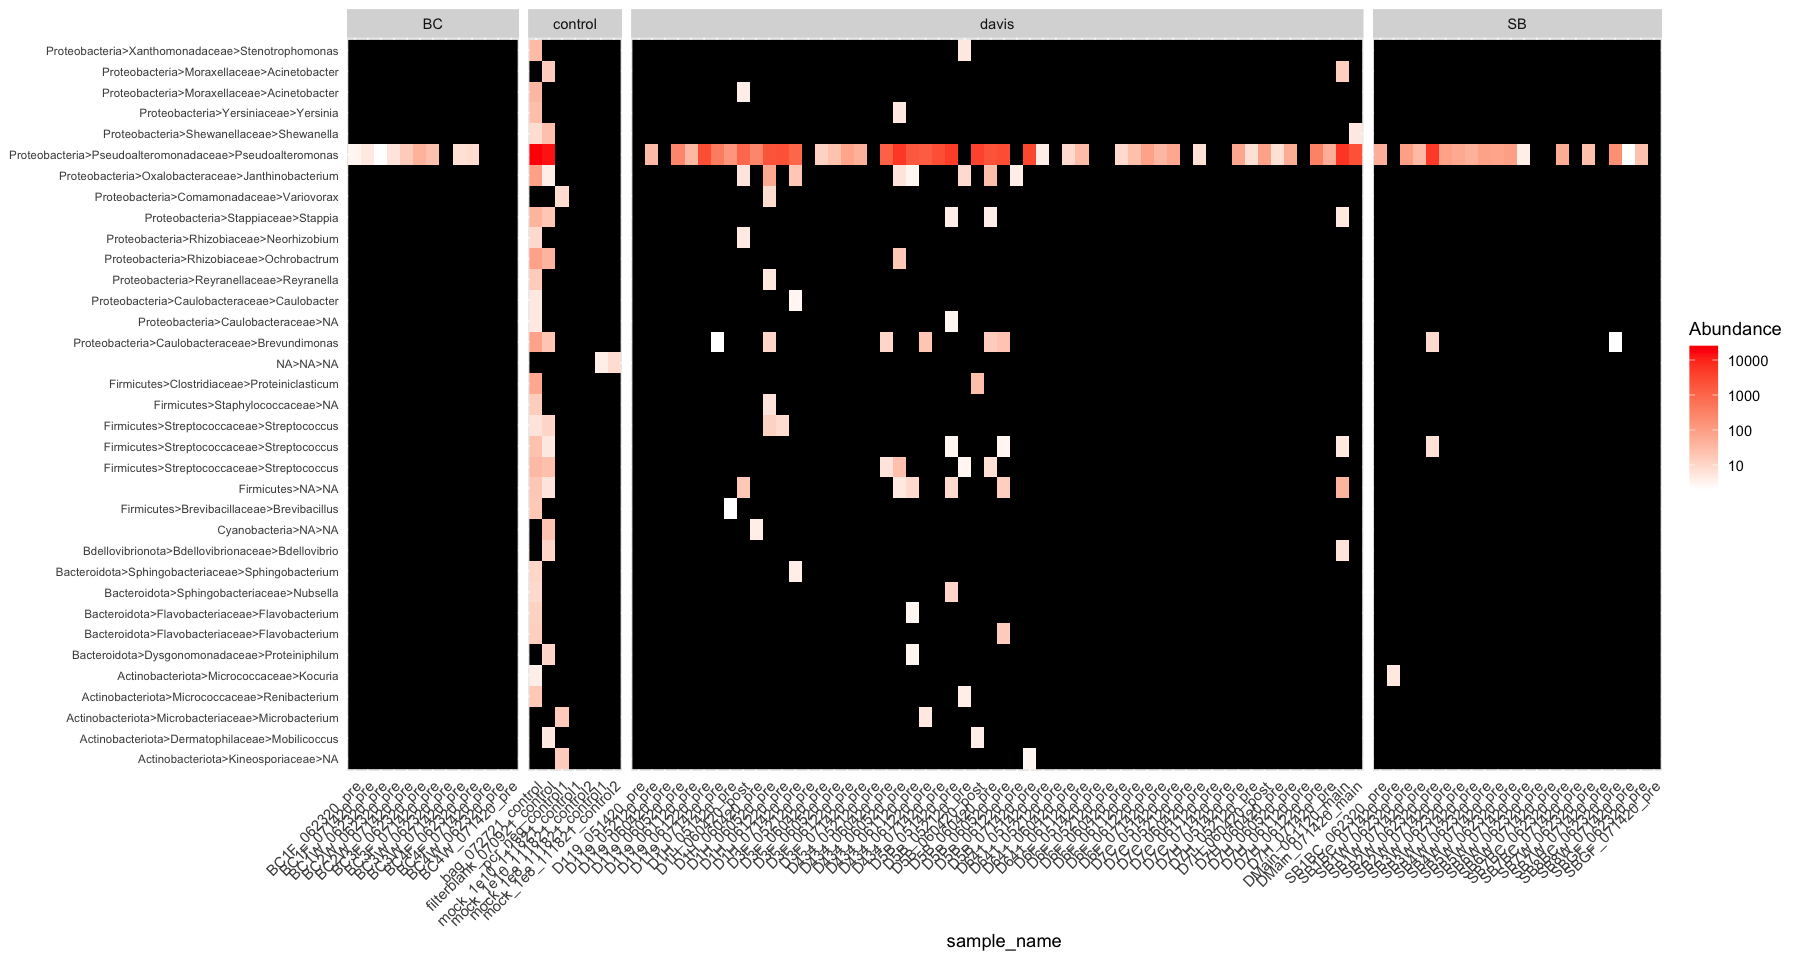

In [62]:
decontam_contams <- c(decontam_freq_intersect, decontam_prev_contams)
ps_decontam_contams <- prune_taxa(decontam_contams, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_decontam_contams, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_prev_contams.png', device='png', width=20, height=9)

Warning message:
“Transformation introduced infinite values in discrete y-axis”


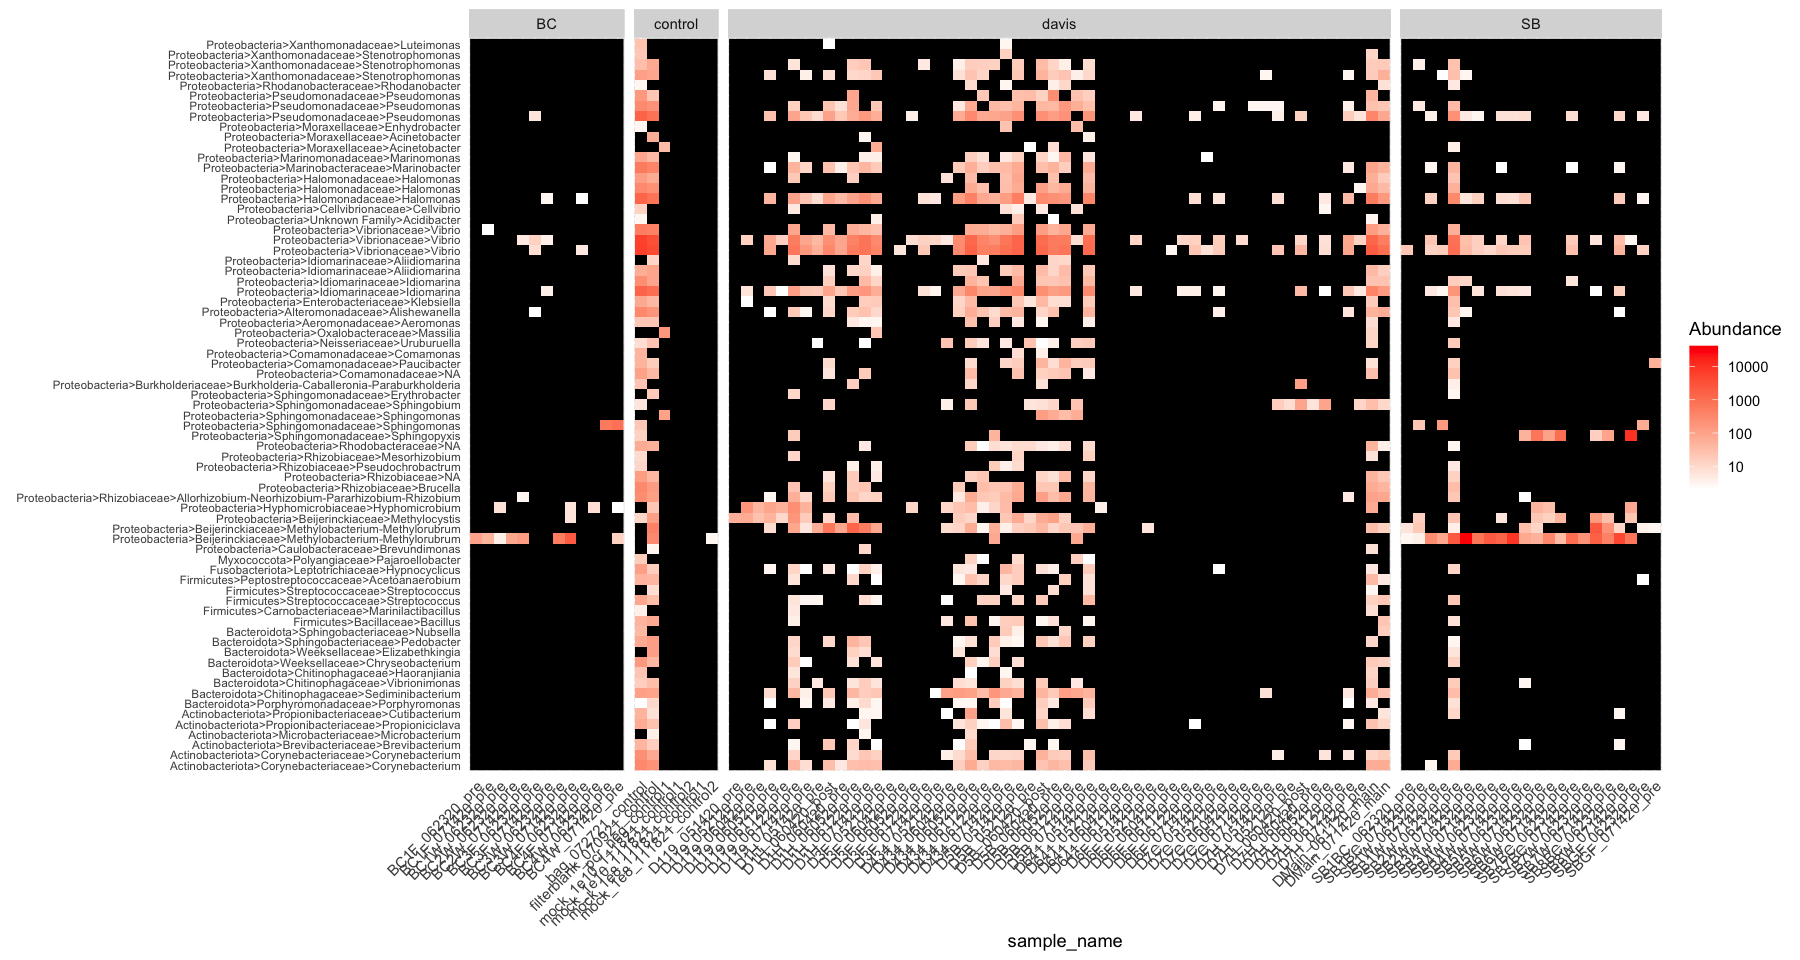

In [63]:
deseq_not_decontam <- setdiff(blanks_over_samples, decontam_contams)
ps_deseq_not_decontam <- prune_taxa(deseq_not_decontam, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_deseq_not_decontam, taxa.label = "combined", sample.label = "sample_name", sample.order = "building", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~building, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_deseq_not_decontam.png', device='png', width=20, height=9)

**Conclusion: These are ASVs flagged by DESeq2 subtraction but not decontam. Several of these ASVs do look like contaminants that should be thrown out and were missed by `decontam`. Some look like they might be biological but the data is too sparse to be sure.  The DESeq2 method as applied here is more stringent than `decontam`, and we will go forward with it.**

**Conclusion: No ASVs flagged by decontam but not DESeq2 subtraction. **